**This notebook shows an example of how to use this module to cluster the field data.**

This is completely analog to what was done for the actual publication. It therefore allows to reproduce the results and also to play with different clustering techniques and parameters.

# Imports

In [1]:
%matplotlib inline
import os
import sys
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mpl_toolkits.axes_grid1 import ImageGrid
sns.set_context('talk')

Import of the modules defined in the `src` module of this project.

In [2]:
# Determine the project directory and at `src` to the python path
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
project_dir = os.path.normpath(os.path.join(workbookDir, os.pardir))
sys.path.insert(0, project_dir)

from src import tools, in_out, visualize as vis

Configure logging to see log messages from the module in the desired format. 

In [3]:
import logging
log_fmt = 'LOG: %(message)s'
logging.basicConfig(level=logging.INFO, format=log_fmt,
                    stream=sys.stdout)

# Clustering

To perform the clustering, we first load the general results from the `parameters_and_results.h5` using the `tools.get_results` function. This dataset links the input parameters (such as polarization, incident angle, ...) to simulation indices, which are then used to find the correct rows in the field database.

**Note** that the full datasets are large! Loading them completely and performing the clustering will need a lot of memory, depending on the clustering technique and parameters. The `tools.get_results` function therefore allows to use only every nth angle and wavelengths, which is convenient and great for testing and to find the system limitations.

In [4]:
every = 10

print 'Loading simulation data, using every', every, 'angles and wavelength.'
sim_data_init = tools.get_results(every, every)
print 'Total number of rows is', len(sim_data_init)

Loading simulation data, using every 10 angles and wavelength.
LOG: Loading parameter and result data frame
Total number of rows is 3854


We now loaded only every 40th wavelength and angle, which is a drastic limitation and will cause quite useless results. But the runtime will be fine and we can see if everything works out well.

In the next step, we need to define the parameters for the clustering procedure. We use the `DEFAULT_SIM_DDICT` and `DEFAULT_SIM_PDICT` dictionaries defined in the `tools` module to have convenient access to the possible parameter names. Note that some of the clustering parameters are defined in this module (see the doc string of `tools.get_clustering_input_data`), while others are specific to the clustering algorithm (e.g. `n_clusters` for `MiniBatchKMeans`).

In [5]:
# Define init parameters
ddict = tools.DEFAULT_SIM_DDICT
pdict = tools.DEFAULT_SIM_PDICT
field_type = 'electric'
cluster_type = 'MiniBatchKMeans'

# Type `tools.get_clustering_input_data?` for info on these parameters
common_clkws = dict(treat_complex=None,
                    preprocess='normalize',
                    random_state=0)  # <- for reproducibility

# Set these defaults for all combinations of direction and polarization
clkw_dicts = tools.defaultdict(dict)
for direc_ in ddict:
    for pol_ in pdict:
        print 'Setting for direction', direc_, ' and polarization', pol_
        clkw_dicts[direc_][pol_] = deepcopy(common_clkws)

# Set individual parameters, in this case for the number of clusters
clkw_dicts['Gamma-K']['TE']['n_clusters'] = 8
clkw_dicts['Gamma-K']['TM']['n_clusters'] = 8
clkw_dicts['Gamma-M']['TE']['n_clusters'] = 7
clkw_dicts['Gamma-M']['TM']['n_clusters'] = 7
clkw_dicts = dict(clkw_dicts)

Setting for direction Gamma-K  and polarization TM
Setting for direction Gamma-K  and polarization TE
Setting for direction Gamma-M  and polarization TM
Setting for direction Gamma-M  and polarization TE


**Note:** To use Gaussian mixture model (GMM) clustering, as for the results in the publication, you have to change the following lines like this:

```python
cluster_type = 'GaussianMixture'
...

common_clkws = dict(covariance_type='tied',
                    max_iter=20,
                    treat_complex=None,
                    preprocess='normalize',
                    random_state=0)
...

clkw_dicts['Gamma-K']['TE']['n_components'] = 8
clkw_dicts['Gamma-K']['TM']['n_components'] = 8
clkw_dicts['Gamma-M']['TE']['n_components'] = 7
clkw_dicts['Gamma-M']['TM']['n_components'] = 7
```

We can moreover activate caching for the functions that query the large database. This will give a huge speedup in field data loading. That means, depending on the value of `every` above, the first call of `cluster_all_modes` below will take some time. As the `MiniBatchKMeans` is incredibly fast, all the following calls will be quick. This allows to play with the parameters, e.g.~ different values for `preprocess` or different `n_clusters`. However, changing the `cluster_type` to `'GaussianMixture'`, for example, will be more time-consuming.

In [6]:
tools.set_cache(True)

LOG: Switched to using cache


We're all set and ready to cluster! All we have to do is to pass the initial simulation data, the clustering type, the clustering parameters and the field type to the `cluster_all_modes` function of the `tools` module. It will return enriched simulation data and the trained models.

In [7]:
sim_data, model_data = tools.cluster_all_modes(sim_data_init,
                                               cluster_type=cluster_type,
                                               cluster_kwargs_dicts=clkw_dicts,
                                               field_type=field_type)

LOG: Clustering for Gamma-K TM
LOG: Reducing data set for pol=TM and direction Gamma-K
LOG: Loading sample data
LOG: Loading time: 0:00:00.294454.
LOG: Running MiniBatchKMeans ...
LOG: Time for clustering: 0:00:00.407639.
LOG: Silhouette score fit: 0.321486278427
LOG: Calculating Euclidian distances
LOG: Updating simulation data set.
LOG: Finished
LOG: Clustering for Gamma-K TE
LOG: Reducing data set for pol=TE and direction Gamma-K
LOG: Loading sample data
LOG: Loading time: 0:00:00.298237.
LOG: Running MiniBatchKMeans ...
LOG: Time for clustering: 0:00:00.476693.
LOG: Silhouette score fit: 0.320344495393
LOG: Calculating Euclidian distances
LOG: Updating simulation data set.
LOG: Finished
LOG: Clustering for Gamma-M TM
LOG: Reducing data set for pol=TM and direction Gamma-M
LOG: Loading sample data
LOG: Collecting field data
LOG: Loading time: 0:37:18.602521.
LOG: Running MiniBatchKMeans ...
LOG: Time for clustering: 0:00:00.406232.
LOG: Silhouette score fit: 0.326807031863
LOG: Calc

# Implemented Plotting

**The `visualize` module contains some utilities to conveniently achieve plots as shown in the main manuscript. We demonstrate the three main implementations here.**

For many of the plotting routines we will need the field metadata, as the field data is stored as flat rows which need to be reshaped properly and assigned to their respective locations in 3D space. The metadata can easily be loaded using:

In [8]:
lengths, pointlist, domain_ids = tools.get_metadata()

LOG: Reading metadata


We choose a subset of the clustering results from above to illustrate the plotting capabilities, in this case the $\Gamma-K$ direction and TE polarization.

In [9]:
direc = 'Gamma-K'
pol = 'TE'

# Some derived identifiers
ipol = tools.POLS.index(pol)
pol_suf = tools.DEFAULT_SIM_PDICT[pol]

# Selection of model and result data from the complete clustering
model = model_data[direc][pol]['model']
sim_nums = model_data[direc][pol]['sim_nums']
data = sim_data.loc[sim_nums]

As in the publication, it makes sense to look at a comparison between the field energy enhancement $E_+$ and the classification map. This can be done using the `compare_values_and_classification` method of the `visualize` module, which calls `imshow_classification_overlay` internally to create the classification map:

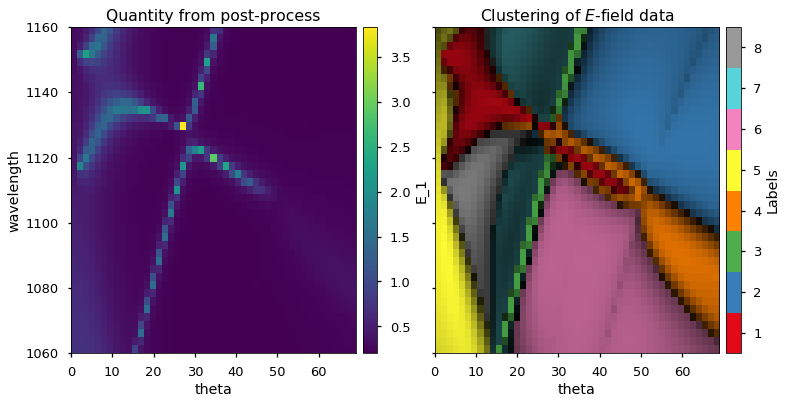

In [10]:
fig = plt.figure(figsize=(12, 6))
# The second parameter can take e.g. `E` for the field enhancement or 'r'/'t'
# for reflectance or transmittance.
_ = vis.compare_values_and_classification(data, 'E', pol_suf, fig,
                                          overlay_kwargs=dict(aspect='auto'),
                                          interpolation='none')

The Silhouette plots are implemented as well:

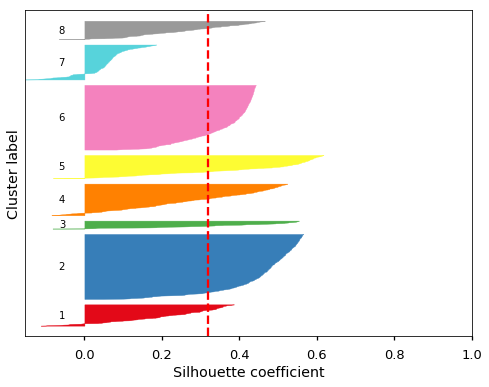

In [11]:
n_clusters = len(model.cluster_centers_) # Number of clusters

plt.figure(figsize=(8,6))
vis.plot_silhouettes(sim_data, pol_suf, sim_nums, ax=plt.gca(),
                     n_clusters=n_clusters)

Plotting of field data is a bit more involved, as we need to reshape the data properly. However, the `visualize` module comes with the `DataOnPlanes` class which simplifies the process. All we have to do is to pass the cluster centers and the metadata and the class will initialize `DataOnPlane` instances, collected in the `planes` list attribute. These planes have their own `imshow`-method which can be used for convenient plotting.

The following shows how to plot the electric energy density distribution of the 0th cluster on the $xy$-plane.

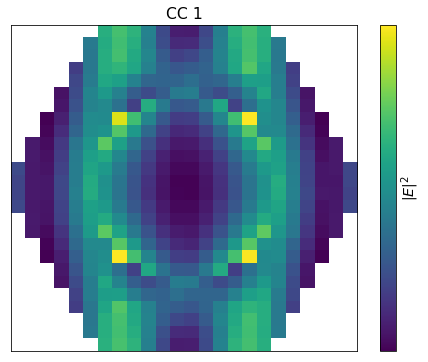

In [12]:
icl = 0 # index of the cluster center (i.e. label)
mcc = model.cluster_centers_[icl]

# Use the `DataOnPlanes` class for convenient restructuring of field data
dups = vis.DataOnPlanes(mcc, pointlist, lengths, domain_ids)

# Use plane Nr. 5, which is the xy-plane in this case
plane = dups.planes[4]

# Use the `imshow` method of the `DataOnPlane` instance for convenient
# plotting
plt.figure(figsize=(8,6))
ax=plt.gca()
_, im = plane.imshow('energy', ax=ax)

# Some styling
ax.set_xticks(()), ax.set_yticks(())
ax.set_title('CC {}'.format(icl + 1))
cb = plt.colorbar(im)
cb.set_ticks(())
cb.set_label('$|E|^2$')

# Overview Plotting and Storage

Finally, the `in_out` module comes with convenience functions for model persistence and also for storing a complete clustering result, using the `save_plots_models` method. This method will
  1. save pickles of the actual models, that can be loaded for later use
  2. save pickles and Excel files for the enriched simulation data, i.e. containing the initial parameters and results plus the classification data
  3. save some basic overview plots of the classification, the fields and the Silhouettes coefficients
All we have to pass is the simulation and model data as returned by `cluster_all_modes` method, plus the metadata in form of a dictionary and a folder path to store the data.

In [13]:
model_dir = os.path.join(tools.PROJECT_DIR, 'models')
metadata = dict(lengths=lengths, pointlist=pointlist, domain_ids=domain_ids)

In [14]:
in_out.save_plots_models(model_dir, sim_data,
                         model_data, cluster_type, metadata)

LOG: Saving model data and plots...
LOG: Treating Gamma-K TM
LOG: Saving pickles
LOG: Plotting...
LOG: Treating Gamma-K TE
LOG: Saving pickles
LOG: Plotting...
LOG: Treating Gamma-M TM
LOG: Saving pickles
LOG: Plotting...
LOG: Treating Gamma-M TE
LOG: Saving pickles
LOG: Plotting...
LOG: Writing data to Excel
LOG: Writing data to pickle
LOG: Writing metadata to compressed numpy file.
LOG: Finished
